In [367]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import gensim

In [277]:
df = pd.read_csv('Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [278]:
df.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [279]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [280]:
df.shape

(53043, 2)

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [282]:
df.apply(pd.isnull).sum()

statement    362
status         0
dtype: int64

In [283]:
df.dropna(subset = ['statement'], axis = 0, inplace = True)

In [284]:
df.shape

(52681, 2)

In [285]:
df.isnull().sum()

statement    0
status       0
dtype: int64

In [286]:
data = df.copy()

In [287]:
sw = stopwords.words('english')

In [288]:
lemmatizer = WordNetLemmatizer()

In [289]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [290]:
data['pre_stat'] = data['statement'].apply(text_preprocessing)

In [291]:
data.head()

,statement,status,pre_stat
0,oh my gosh,Anxiety,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,shifted focus something else still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean


In [292]:
data.drop(columns = ['statement'], axis = 1, inplace = True)

In [293]:
data.head()

,status,pre_stat
0,Anxiety,oh gosh
1,Anxiety,trouble sleeping confused mind restless heart ...
2,Anxiety,wrong back dear forward doubt stay restless re...
3,Anxiety,shifted focus something else still worried
4,Anxiety,restless restless month boy mean


In [294]:
data['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [295]:
data_normal = data[data['status'] == 'Normal'].sample(10652)
data_depression = data[data['status'] == 'Depression'].sample(10652)
data_suicidal = data[data['status'] == 'Suicidal']

In [296]:
data = pd.concat([data_normal, data_depression, data_suicidal])

In [297]:
data['status'].value_counts()

status
Normal        10652
Depression    10652
Suicidal      10652
Name: count, dtype: int64

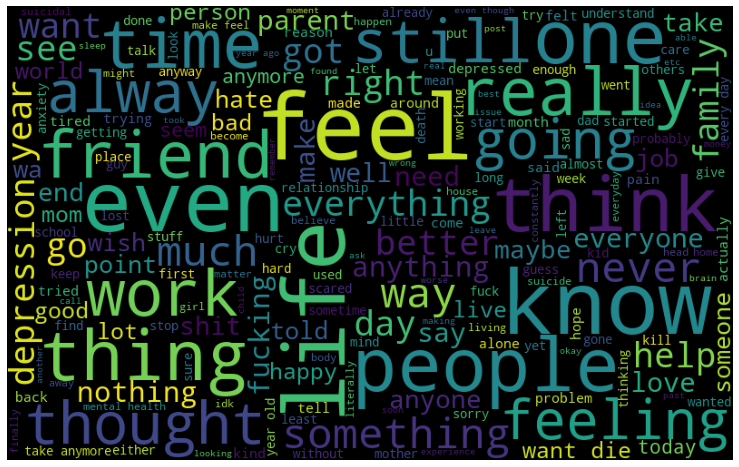

In [298]:
plt.figure(figsize = (13, 9))
all_sen = ' '.join([sentence for sentence in data['pre_stat']])
wordcloud_all = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sen)
plt.imshow(wordcloud_all)
plt.axis('off')
plt.show()

In [299]:
def word_cloud(st):
    plt.figure(figsize = (13, 9))
    sen = ' '.join([sentence for sentence in data['pre_stat'][data['status'] == st]])
    wordcloud_sen = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 100).generate(sen)
    plt.imshow(wordcloud_sen)
    plt.axis('off')
    plt.show()

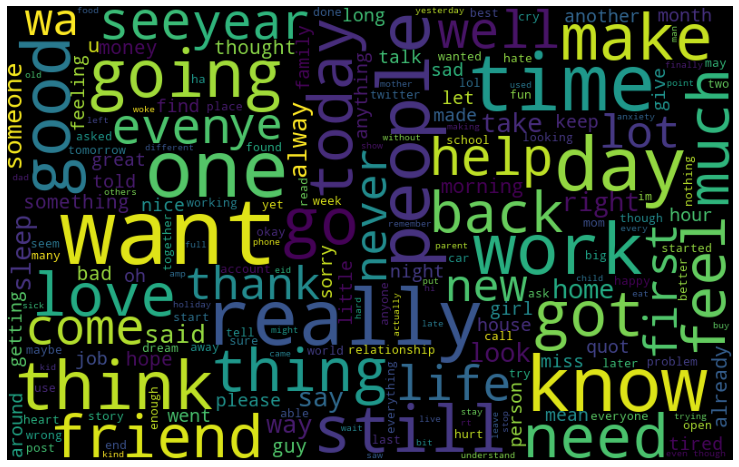

In [300]:
word_cloud('Normal')

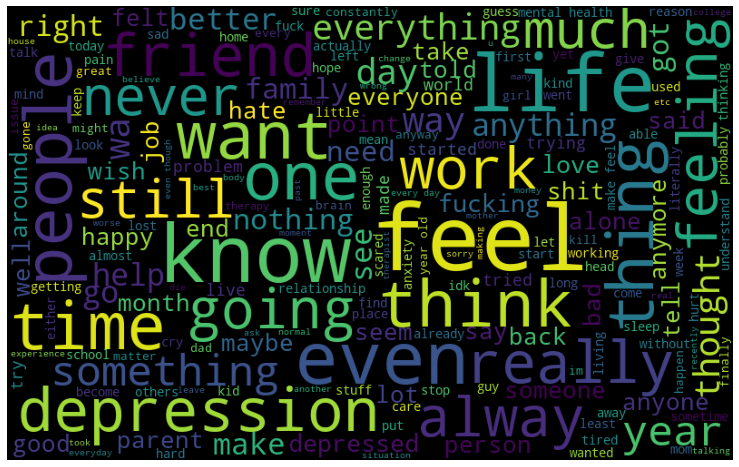

In [301]:
word_cloud('Depression')

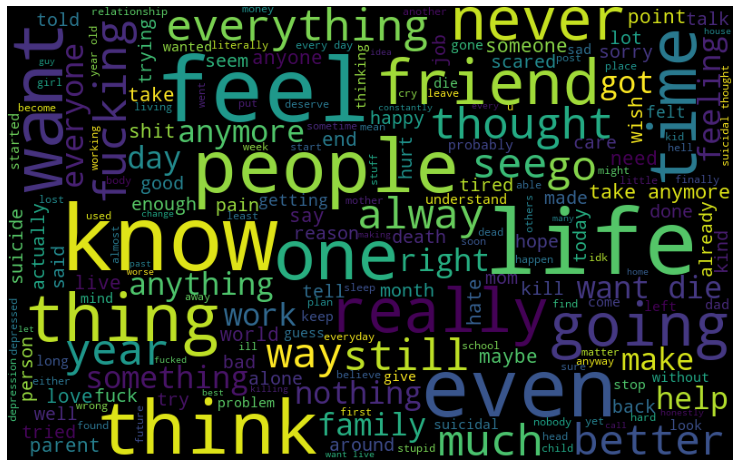

In [302]:
word_cloud('Suicidal')

In [303]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['pre_stat'])
seq = tokenizer.texts_to_sequences(data['pre_stat'])

In [304]:
seq[:10]

[[15, 5024, 272],
 [120,
  2108,
  4142,
  107,
  13,
  139,
  46,
  2681,
  1988,
  219,
  46,
  122,
  3716,
  11794,
  193,
  1988,
  11795],
 [461, 4874, 8484, 53, 511, 5025, 1338, 18777, 3, 3, 3, 18778, 14, 540],
 [14132, 448, 448, 448],
 [6,
  2375,
  3939,
  35,
  21,
  101,
  540,
  966,
  741,
  87,
  262,
  966,
  6,
  29,
  207,
  280,
  194,
  891,
  1250,
  265,
  1820,
  5575,
  262,
  1269,
  42,
  17,
  10,
  1120,
  9275,
  10,
  2307],
 [218, 102],
 [102, 288, 14133, 9, 521, 26, 1698, 1407],
 [9276, 211, 17, 18779],
 [312, 15],
 [14134, 8, 212, 5373, 196, 1572, 262]]

In [305]:
maxlen = 500

In [306]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

39747

In [307]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')
pad_seq[:10]

array([[   15,  5024,   272, ...,     0,     0,     0],
       [  120,  2108,  4142, ...,     0,     0,     0],
       [  461,  4874,  8484, ...,     0,     0,     0],
       ...,
       [ 9276,   211,    17, ...,     0,     0,     0],
       [  312,    15,     0, ...,     0,     0,     0],
       [14134,     8,   212, ...,     0,     0,     0]])

In [308]:
glove_file = open('glove.6B.100d.txt', encoding = 'utf8')
embedding_vec = dict()
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_vec[word] = vector
glove_file.close()

In [309]:
len(embedding_vec['good'])

100

In [310]:
embedding_vector = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_vec.get(word)
    if vec is not None:
        embedding_vector[index] = vec

In [311]:
embedding_vector

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.042895  ,  0.70670998,  0.75316   , ..., -0.54229999,
         0.11809   ,  0.39974001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14905   , -0.069206  , -0.23901001, ...,  0.48605001,
        -0.37207001,  0.17437001]])

In [312]:
X = pad_seq

In [313]:
y = data['status']

In [314]:
le = LabelEncoder()
y_le = le.fit_transform(y)

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size = 0.2, random_state = 101, stratify = y_le, 
                                                   shuffle = True)

In [331]:
X_train.shape

(25564, 500)

In [332]:
X_test.shape

(6392, 500)

In [339]:
model1 = Sequential()

In [340]:
model1.add(Input(shape = (maxlen, )))
model1.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vector), trainable = False))
model1.add(Dropout(0.4))
model1.add(Bidirectional(LSTM(15)))
model1.add(Dropout(0.4))
model1.add(Dense(3 , activation = 'softmax'))

In [341]:
model1.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [342]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [344]:
history = model1.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 199s 272ms/step - accuracy: 0.5605 - loss: 0.8522 - val_accuracy: 0.7227 - val_loss: 0.6068
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 201s 279ms/step - accuracy: 0.7308 - loss: 0.5945 - val_accuracy: 0.7732 - val_loss: 0.5198
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 201s 279ms/step - accuracy: 0.7785 - loss: 0.5097 - val_accuracy: 0.7923 - val_loss: 0.4964
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 200s 279ms/step - accuracy: 0.8114 - loss: 0.4524 - val_accuracy: 0.8045 - val_loss: 0.4647
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 222s 308ms/step - accuracy: 0.8424 - loss: 0.3950 - val_accuracy: 0.8064 - val_loss: 0.4633
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 206s 287ms/step - accuracy: 0.8604 - loss: 0.3588 - val_accuracy: 0.8060 - val_loss: 0.4849
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 210s 292ms/step - accuracy: 0.8779 - loss: 0.3134 - val_accuracy: 0.8017 - val_loss: 0.5196


In [345]:
model1.evaluate(X_test, y_test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.7931 - loss: 0.5342


[0.5274717807769775, 0.796933650970459]

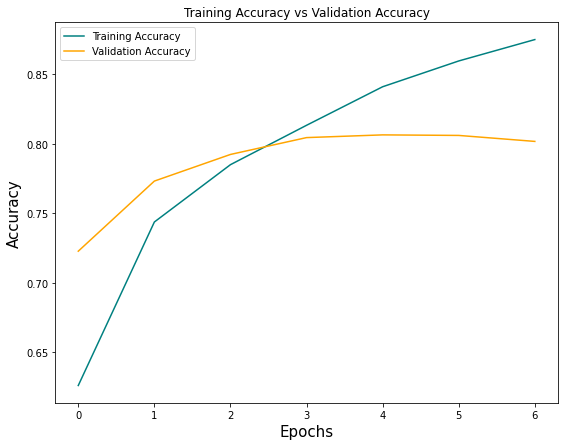

In [347]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.show()

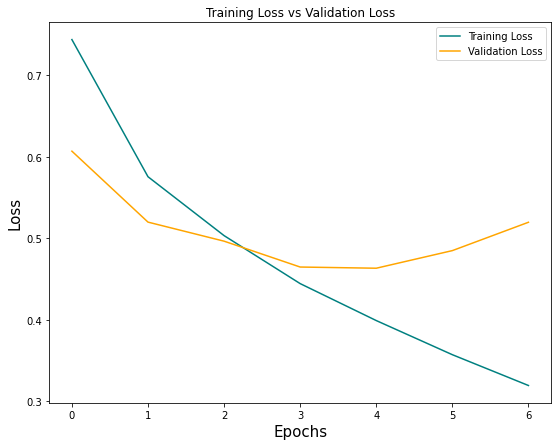

In [348]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.show()

In [349]:
y_p1 = model1.predict(X_test)
y_pred1 = [np.argmax(i) for i in y_p1]

200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step


In [351]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      2131
           1       0.94      0.93      0.94      2131
           2       0.72      0.74      0.73      2130

    accuracy                           0.80      6392
   macro avg       0.80      0.80      0.80      6392
weighted avg       0.80      0.80      0.80      6392



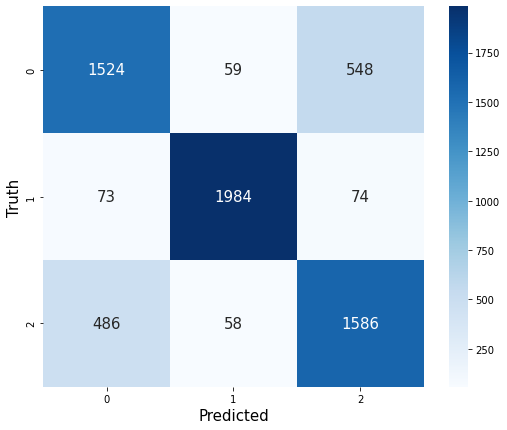

In [352]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_pred1), annot = True, square = True, cbar = True, annot_kws = {'size' : 15}, fmt = 'd',
           cmap = 'Blues')
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Truth', fontsize = 15)
plt.show()

In [363]:
model2 = Sequential()

In [364]:
model2.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vector), trainable = False))
model2.add(Conv1D(32, 3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling1D(pool_size = 2))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.2))
model2.add(Dense(3, activation = 'softmax'))

In [365]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [366]:
history2 = model2.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 130s 172ms/step - accuracy: 0.6256 - loss: 0.7348 - val_accuracy: 0.7716 - val_loss: 0.5302
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 128s 177ms/step - accuracy: 0.7955 - loss: 0.4756 - val_accuracy: 0.7947 - val_loss: 0.4782


In [368]:
ap_sen = data['pre_stat'].apply(gensim.utils.simple_preprocess)

In [369]:
ap_sen

6939                                       [day, mv, came]
41926    [sleep, til, noon, wa, one, left, got, tempted...
43271    [oh, em, gee, love, http, tinyurl, com, djjc, ...
3658                                       [yes, yes, yes]
28781    [get, shelter, employed, still, make, enough, ...
                               ...                        
37651    [rt, kindfashionny, please, see, need, human, ...
37652    [knowing, damn, well, hate, taking, anyways, h...
37654                            [damn, crazy, life, mine]
37655    [day, feel, deeply, depressed, highly, sensiti...
37657    [standing, supermarket, line, thinking, feel, ...
Name: pre_stat, Length: 31956, dtype: object

In [370]:
w2v_model = gensim.models.Word2Vec(
    window = 15, 
    min_count = 2,
    workers = 4
)

In [371]:
w2v_model.build_vocab(ap_sen, progress_per = 1000)

In [373]:
w2v_model.train(ap_sen, total_examples = data.shape[0], epochs = 30)

(40763159, 46519830)

In [400]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    try:
        vec2 = w2v_model.wv[word]
        embedding_vectors[index] = vec2
    except:
        pass

In [405]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01759008, -3.29865742, -2.15224719, ..., -0.26723081,
        -0.86760449, -0.61684501],
       [-0.48605013, -3.07327271, -0.35283244, ..., -0.33126059,
        -2.71545625,  0.92926061],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [416]:
model3 = Sequential()

In [417]:
model3.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vector), trainable = False))
model3.add(Conv1D(32, 3, padding = 'same', activation = 'relu'))
model3.add(MaxPooling1D(pool_size = 2))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dropout(0.2))
model3.add(Dense(3, activation = 'softmax'))

In [418]:
model3.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [419]:
history3 = model3.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 132s 176ms/step - accuracy: 0.6361 - loss: 0.7297 - val_accuracy: 0.7802 - val_loss: 0.4999
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 127s 176ms/step - accuracy: 0.7994 - loss: 0.4706 - val_accuracy: 0.7947 - val_loss: 0.4763


In [420]:
model4 = Sequential()

In [421]:
model4.add(Input(shape = (maxlen, )))
model4.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vector), trainable = False))
model4.add(Dropout(0.4))
model4.add(Bidirectional(LSTM(15)))
model4.add(Dropout(0.4))
model4.add(Dense(3 , activation = 'softmax'))

In [422]:
model4.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [423]:
history4 = model4.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 198s 270ms/step - accuracy: 0.5935 - loss: 0.8265 - val_accuracy: 0.7278 - val_loss: 0.5856
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 196s 272ms/step - accuracy: 0.7429 - loss: 0.5877 - val_accuracy: 0.7790 - val_loss: 0.5141
